In [40]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil, os, random,cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split, KFold

In [4]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# **1. Descargar y preparar conjunto de datos**

### Funciones anónimas para obtener las categorías de cada imágen

In [5]:
isStego=lambda x:1 if x[:6]=="stego_" else 0
getYFromImageList=lambda x: [isStego(element) for element in x]

In [6]:
folder="./MonoSamples/WOW_5/"

In [7]:
images= os.listdir(folder) #[x[0] for x in os.walk("./readySamples/WOW_5")]
random.shuffle(images)

In [8]:
len(images)

40000

### Orden aleatorio del dataset

### Obteniendo las categorías

In [9]:
y=np.array(getYFromImageList(images),dtype='float32')

In [10]:
y.shape

(40000,)

In [11]:
y

array([1., 1., 0., ..., 1., 0., 0.], dtype=float32)

In [12]:
plt.imshow(mpimg.imread(folder+images[15]))
plt.show()

### Obteniendo data de x

In [13]:
import time

# Acá se usan 30GB de memoria (?) algo raro está pasando, de pronto hay que convertirlo a np array en otra línea. List comprehension usa mucha memoria...

In [20]:
#.reshape(49152)
#/255,dtype='int8'
#Editar tamaño de muestra
#Editar canal
x=np.array([mpimg.imread(folder+images[i]) for i in range(len(images))],dtype=tf.float32)

In [16]:
import gc
gc.enable()
gc.collect()
gc.garbage

[]

In [21]:
print(x.shape)

(40000, 128, 128)


#Aqeuí realizar el cálculo del tiempo con los diferentes métodos (.append, con diccionario, con list comprehension, con reshape directamente, sin reshape)

from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(x)
X_scaled[:5]

features = X_scaled.T
cov_matrix = np.cov(features)
cov_matrix[:5]

values, vectors = np.linalg.eig(cov_matrix)
values[:5]

vectors[:5]

### Dividiendo entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

#reshape data to fit model
X_train = X_train.reshape(71647,128,128,3)
X_test = X_test.reshape(17912,128,128,3)

# **3. Base Convolucional**

In [22]:
# Custom filter
def high_pass(shape, dtype=None):
    f = np.zeros(shape, dtype='float32')
    f[:,:,0,0] = np.array([
            [ -1,  2 ,  -2,  2 ,  -1],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -2,  8 , -12,  8 ,  -2 ],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -1,  2 ,  -2,  2 ,  -1]
        ],dtype = 'float')
    f/=12    
    return K.variable(f, dtype='float32')

In [23]:
kf = KFold(n_splits=5, shuffle=False)
acc_per_fold = []
loss_per_fold = []

In [34]:
[[y[i],images[i]] for i in range(1,20)]

[[1.0, 'stego_521_n02640242_6739.JPEG'],
 [0.0, '741_n02167151_8565.JPEG'],
 [1.0, 'stego_426_n03447447_935.JPEG'],
 [1.0, 'stego_781_n02012849_10612.JPEG'],
 [1.0, 'stego_348_n02119789_4272.JPEG'],
 [1.0, 'stego_228_n04090263_1133.JPEG'],
 [1.0, 'stego_785_n07718747_7324.JPEG'],
 [0.0, '770_n04604644_11638.JPEG'],
 [0.0, '722_n07717410_2350.JPEG'],
 [1.0, 'stego_577_n04479046_14951.JPEG'],
 [0.0, '913_n02389026_24702.JPEG'],
 [0.0, '478_n03769881_1160.JPEG'],
 [1.0, 'stego_426_n03447447_13302.JPEG'],
 [1.0, 'stego_360_n02106030_8406.JPEG'],
 [1.0, 'stego_791_n03814639_6975.JPEG'],
 [1.0, 'stego_724_n03956157_17275.JPEG'],
 [1.0, 'stego_392_n02085782_16204.JPEG'],
 [1.0, 'stego_846_n01784675_3401.JPEG'],
 [1.0, 'stego_456_n03017168_43234.JPEG']]

In [30]:
x=x.reshape(len(x),128,128,1)

In [25]:
gc.collect()

8

In [26]:
for asd, das in kf.split(x,y):
    print(len(x[asd]),len(x[das]))

32000 8000
32000 8000
32000 8000
32000 8000
32000 8000


In [29]:
x.shape

(40000, 128, 128)

In [35]:
gc.collect()

5739

In [46]:
x[0].shape

(128, 128, 1)

as [  0   1   2   3 252 253 254 255]


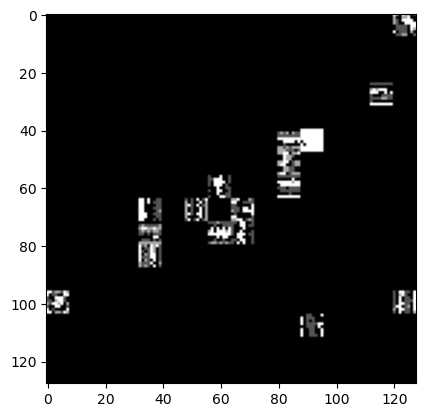

In [78]:
cover=mpimg.imread("cover1.JPEG")#[:,::-1]
stego=mpimg.imread("stego1.JPEG")#[:,::-1]
print("as",np.unique(cover-stego))
plt.imshow((cover-stego)*63,cmap='gray' )#(cover-stego)*255)#-stego)*255)
plt.show()

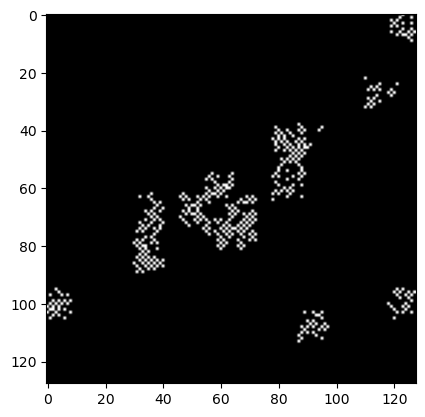

In [100]:
from scipy import ndimage
kernal=   np.array([
            [ -1,  2 ,  -2,  2 ,  -1],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -2,  8 , -12,  8 ,  -2 ],
            [ 2 , -6 ,  8 , -6 ,  2 ],
            [ -1,  2 ,  -2,  2 ,  -1]
        ],dtype = 'float')/12  
    
plt.imshow(ndimage.convolve(cover, kernal)-ndimage.convolve(stego, kernal),cmap='gray')#-ndimage.convolve(stego, kernal)
plt.show()

In [141]:
gc.collect()

29655

# Acá también se usa mucha memoria

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/200
500/500 [==============================] - 4294s 9s/step - loss: 7.6431 - accuracy: 0.5002 - f1_m: 0.6644 - precision_m: 0.5002 - recall_m: 1.0000 - val_loss: 7.6685 - val_accuracy: 0.4995 - val_f1_m: 0.6641 - val_precision_m: 0.4995 - val_recall_m: 1.0000
Epoch 2/200
500/500 [==============================] - 4437s 9s/step - loss: 7.6686 - accuracy: 0.5002 - f1_m: 0.6646 - precision_m: 0.5002 - recall_m: 1.0000 - val_loss: 7.6685 - val_accuracy: 0.4995 - val_f1_m: 0.6641 - val_precision_m: 0.4995 - val_recall_m: 1.0000
Epoch 3/200
500/500 [==============================] - 4426s 9s/step - loss: 7.6686 - accuracy: 0.5002 - f1_m: 0.6643 - precision_m: 0.5002 - recall_m: 1.0000 - val_loss: 7.6685 - val_accuracy: 0.4995 - val_f1_m: 0.6641 - val_precision_m: 0.4995 - val_recall_m: 1.0000
Epoch 4/200
500/500 [==============================] - 4406s 9s/step - loss: 7.6686 - accuracy: 

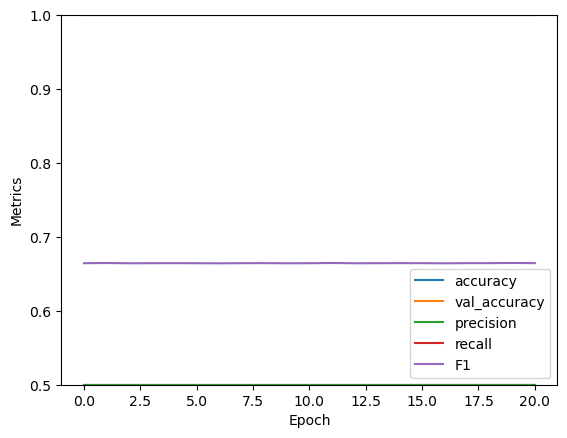

Next fold
Score for fold 1: loss of 7.6685004234313965; accuracy of 49.950000643730164%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/200
500/500 [==============================] - 4368s 9s/step - loss: 0.6932 - accuracy: 0.4998 - f1_m: 0.6634 - precision_m: 0.4991 - recall_m: 0.9996 - val_loss: 0.6931 - val_accuracy: 0.4959 - val_f1_m: 0.6669 - val_precision_m: 0.5031 - val_recall_m: 0.9984
Epoch 2/200
500/500 [==============================] - 4335s 9s/step - loss: 0.6931 - accuracy: 0.4973 - f1_m: 0.6618 - precision_m: 0.4993 - recall_m: 0.9918 - val_loss: 0.6931 - val_accuracy: 0.4949 - val_f1_m: 0.6598 - val_precision_m: 0.5033 - val_recall_m: 0.9672
Epoch 3/200
500/500 [==============================] - 4328s 9s/step - loss: 0.6931 - accuracy: 0.4973 - f1_m: 0.6452 - precision_m: 0.5003 - recall_m: 0.9350 - val_loss: 0.6931 - val_accuracy: 0.5059 - val_f1_m: 0.6616 - val_precision_m: 0.5042 - val_recall_m: 0.9715
Epoch 4/

KeyboardInterrupt: 

In [145]:
#Setting early stopping
earlystopping=callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=20,restore_best_weights=True)
#Conv
fold_no = 1
for train, test in kf.split(x, y):
    model = models.Sequential()
    model.add(layers.Conv2D(128,(5,5), padding='valid',strides=[1, 1],
                          input_shape=(128, 128,1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(512, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
    #Dense
    model.add(layers.Flatten())#, activation='relu'
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    #Comp
    customSGD=tf.optimizers.SGD(learning_rate=0.1)
    #customAdam=tf.optimizers.Adam(learning_rate=0.05)
    model.compile(optimizer=customSGD,
                  loss=tf.keras.losses.binary_crossentropy, #Debería ser binario?
                  metrics=['accuracy',f1_m,precision_m, recall_m])
        # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    #Fitting
    history = model.fit(x[train], y[train],validation_data=(x[test], y[test]), epochs=200, callbacks=[earlystopping],batch_size=64)
    gc.collect()
    print("\n\n\n\n\nFitted")
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    test_loss, test_acc,f1_score, precision, recall = model.evaluate(x[test], y[test], verbose=2)
    print("Loss:",test_loss, "\nAccuracy:",test_acc,"\nF1 score:",f1_score, "\nPrecision:",precision, "\nRecall",recall)
        
    plt.plot(history.history['precision_m'], label='precision')
    plt.plot(history.history['recall_m'], label = 'recall')
    plt.plot(history.history['f1_m'], label = 'F1')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.legend(loc='lower right')
    plt.show()
    print("Next fold")
    #dataMqtt={"Fold":str(fold_no),"timestamp":str(datetime.now()),"Loss":str(test_loss), "Acc":str(test_acc),"F1":str(f1_score),"Precision":str( precision),"Recall": str(recal)}
    #dataMqtt_out=json.dumps(data)
    #retMqtt= client1.publish("stegian/data",dataMqtt_out)
    
    # Generate generalization metrics
    scores = model.evaluate(x[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no += 1
    gc.collect()

In [138]:
x.shape

(40000, 128, 128, 1)

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

#model.build((None,128,128,3))
model.summary()

# **4. Agregar capas densas en la parte superior**

In [ ]:
model.summary()

# **5. Compilar y entrenar el modelo**



In [ ]:
model.save("CNNv2_Mono_WOW5.h5")

# **6. Evaluar el modelo**